# Benchmarking binding classification with XGBoost and NN stacked


----

Stacking xgboost and NN predictions in a meta estimator.

----

- Cross validation using the train data and evaluation on 'blind test set'.

- Using all observations (all species, </=/> values too)

- simple one-hot encoding scheme for all categorical variables (species, hla type/subtypes,sequence)

- This is the best i can do now


----

In [1]:
import os,sys
os.environ['THEANO_FLAGS']='device=gpu1'

#my functions
sys.path.append('../')
from utils import load_data,my_xgb_cv_predict,my_xgb_fit_predict,my_keras_cv_predict,my_keras_fit_predict,plot_roc

#go to working dir
work_dir='/data/data1/ribli/mhc/'
os.chdir(work_dir)

%matplotlib inline

Using Theano backend.
Using gpu device 1: GeForce GTX 670 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5004)


### Load train and test data

In [2]:
X_train,y_train,y_train_c,X_test,y_test,y_test_c,=load_data(
    hla_representation='one-hot',
    species_representation='one-hot',
    seq_representation='one-hot')

----


### Get xgboost CV predictions on train data, and test data


In [3]:
#model params
params = {'max_depth':20,
         'eta':0.1,
         'min_child_weight':5,
         'colsample_bytree':1,
         'subsample':1,
         'silent':1,
         'objective': "binary:logistic",
         'eval_metric': 'auc',
         'nthread':8}

xgb_train_pred=my_xgb_cv_predict(params,X_train,y_train_c,n_folds=5)

xgb_test_pred=my_xgb_fit_predict(params,X_train,y_train_c,X_test,
                       num_boost_round=5000,verbose_eval=500,
                       early_stopping_rounds=200,
                       validation_size=0.1)

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.840747	eval-auc:0.816781
[500]	train-auc:0.991175	eval-auc:0.925939
[1000]	train-auc:0.997229	eval-auc:0.927180
[1500]	train-auc:0.998937	eval-auc:0.927381
Stopping. Best iteration:
[1574]	train-auc:0.999076	eval-auc:0.927458

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.818925	eval-auc:0.786143
[500]	train-auc:0.990922	eval-auc:0.929861
[1000]	train-auc:0.997037	eval-auc:0.931522
Stopping. Best iteration:
[1086]	train-auc:0.997519	eval-auc:0.931662

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.834966	eval-auc:0.808328
[500]	train-auc:0.990853	eval-auc:0.931654
[1000]	train-auc:0.996985	eval-auc:0.933061
Stopping. Best iteration:
[1034]	train-auc:0.997187	eval-auc:0.933136

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.827853	eval-auc:0.804454
[500]	train-auc:0.991164	eval-auc:0.927565
Stopping. Best iteration:
[753]	tra

### Do the same with NN

In [10]:
#create a very simple model
from keras.models import Sequential
from keras.layers import Dense

#create model creator
def get_model(input_dim):
    """Creates Keras model needed."""
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

#predict CV
nn_train_pred=my_keras_cv_predict(get_model,X_train,y_train_c,n_folds=5,patience=3,verbose=2)

#predict test set
nn_test_pred=my_keras_fit_predict(get_model,X_train,y_train_c,X_test,
                      validation_split=0.1,patience=3,nb_epoch=100)

Train on 99110 samples, validate on 11013 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.34722, saving model to best_model
2s - loss: 0.4286 - val_loss: 0.3472
Epoch 2/100
Epoch 00001: val_loss improved from 0.34722 to 0.30947, saving model to best_model
2s - loss: 0.3229 - val_loss: 0.3095
Epoch 3/100
Epoch 00002: val_loss improved from 0.30947 to 0.29652, saving model to best_model
2s - loss: 0.2823 - val_loss: 0.2965
Epoch 4/100
Epoch 00003: val_loss did not improve
2s - loss: 0.2522 - val_loss: 0.3066
Epoch 5/100
Epoch 00004: val_loss did not improve
2s - loss: 0.2278 - val_loss: 0.3101
Epoch 6/100
Epoch 00005: val_loss did not improve
2s - loss: 0.2069 - val_loss: 0.3011
Epoch 7/100
Epoch 00006: val_loss did not improve
Epoch 00006: early stopping
2s - loss: 0.1857 - val_loss: 0.3146
Train on 99110 samples, validate on 11013 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.34414, saving model to best_model
2s - loss: 0.4243 - val_loss: 0.3441
Epoc

### Create stacked inputs

In [11]:
import numpy as np
X_train_stacked=np.column_stack([X_train,xgb_train_pred,nn_train_pred])
X_test_stacked=np.column_stack([X_test,xgb_test_pred,nn_test_pred])

#save them for the future
np.save('stacked_x_train',X_train_stacked)
np.save('stacked_x_test',X_test_stacked)

### Make prediction with xgb on the stacked inputs

In [93]:
params = {'max_depth':2,
         'eta':0.1,
         'min_child_weight':5,
         'colsample_bytree':1,
         'subsample':1,
         'silent':1,
         'objective': "binary:logistic",
         'eval_metric': 'auc',
         'nthread':8}


xgb_stacked_train_pred=my_xgb_cv_predict(params,X_train_stacked,y_train_c,n_folds=5)

xgb_stacked_test_pred=my_xgb_fit_predict(params,X_train_stacked,y_train_c,X_test_stacked,
                       num_boost_round=5000,verbose_eval=500,
                       early_stopping_rounds=200,
                       validation_size=0.1)

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.909587	eval-auc:0.911229
Stopping. Best iteration:
[111]	train-auc:0.937195	eval-auc:0.938315

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.910550	eval-auc:0.914403
Stopping. Best iteration:
[79]	train-auc:0.937841	eval-auc:0.938805

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.910032	eval-auc:0.911884
Stopping. Best iteration:
[83]	train-auc:0.938123	eval-auc:0.936311

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.909331	eval-auc:0.912317
Stopping. Best iteration:
[122]	train-auc:0.938615	eval-auc:0.938433

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.908376	eval-auc:0.912621
Stopping. Best iteration:
[83]	train-auc:0.937550	eval-auc:0.938755

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.909954	eval-auc:0.910380
[500]	train-auc:0.939266	eval-auc:0.937646
Stop

### Evaluate

In [94]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
def bootstrap_auc(y_c,y_pred,N=100):
    """Bootstrap the AUC score."""
    scores=[]
    for i in xrange(N):
        res_y=resample(np.column_stack([y_c,y_pred]))
        scores.append(roc_auc_score(res_y[:,0],res_y[:,1]))
        
    print 'Score is :', '%.4f' % np.mean(scores),
    print '+-','%.4f' % np.std(scores)

In [95]:
bootstrap_auc(y_train_c,xgb_stacked_train_pred)

Score is : 0.9362 +- 0.0006


AUC: 0.936296021463


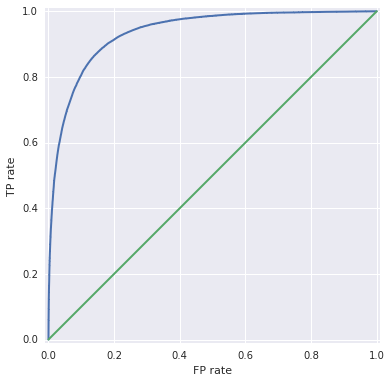

In [96]:
plot_roc(y_train_c,xgb_stacked_train_pred)

In [97]:
bootstrap_auc(y_test_c,xgb_stacked_test_pred)

Score is : 0.9163 +- 0.0018


AUC: 0.916494400545


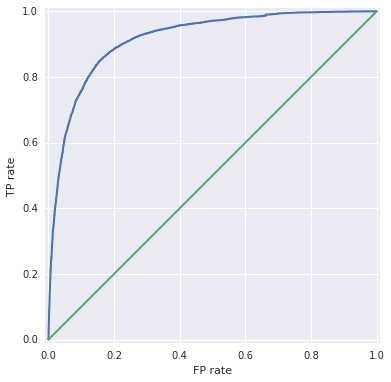

In [98]:
plot_roc(y_test_c,xgb_stacked_test_pred)

---

## Conclusion: passed 'state of the art'

Method | CV | Blind test
--- | --- | ---
SMMPMBEC | 0.8989 | 0.8474
NetMHC | 0.8930 | 0.8833
NetMHCpan |0.9176 | 0.8830
xgboost + NN |**0.9362** | **0.9163**


---
